In [200]:
import pandas as pd
import numpy as np
import os as os
import matplotlib.pyplot as plt
from shutil import rmtree
import cv2 as cv2


def summary(Dff):
    Oper = [Dff.min(),
      np.percentile(Dff, 1),
      np.percentile(Dff,10),
      np.percentile(Dff, 25),
      Dff.mean(),
      np.median(Dff),
      np.percentile(Dff, 75),
      np.percentile(Dff, 90),
      np.percentile(Dff, 99),
      Dff.max()]
    Nms = ['Min','1%','10%','25%','mean','median','75%','90%','99%','max']
    
    Oper_ind_sort = np.array(Oper).argsort()
    Oper = [Oper[x] for x in Oper_ind_sort] #Oper[Oper_ind_sort]
    Nms = [Nms[x] for x in Oper_ind_sort] #Nms[Oper_ind_sort]
    
    Oper.append(Dff.std())
    Nms.append('std')
    
    display(pd.DataFrame(list(zip(Nms, Oper)), columns = ['Oper','Value']).transpose())

Okay, so what's gonna happen here is I'm going to read in each parquet file, crop them, and then randomly split them between a test and train set. Why? So that it's far eiser to user the ImageDataGenerator

First Off, let's read in the Data

In [36]:
Df = pd.read_parquet('../Data/train_image_data_1.parquet')
#2.48GB in size

In [37]:
Df_np = 255 - Df.iloc[:,1:].values.reshape(50210, 137,236)
Df_l = Df.iloc[:,0].values

Let's take a look where the writting actually falls

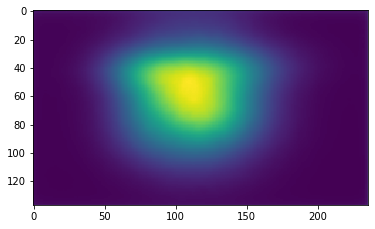

In [38]:
Df_Avg = Df_np[:,:,:].mean(axis = 0)
plt.imshow(Df_Avg)

In [39]:
summary(Df_Avg)

,0,1,2,3,4,5,6,7,8,9,10
Oper,Min,1%,10%,25%,median,mean,75%,90%,99%,max,std
Value,1.22521,1.28831,1.63905,2.14742,5.26965,13.5254,17.8059,41.7385,65.9846,69.3623,16.8242


Okay, let's take out any values above the 5th percentile to get a sense, visually, of where the extermes actually lay

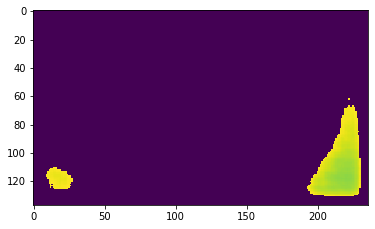

In [40]:
Df_Avg[Df_Avg > np.percentile(Df_Avg,5)] = 0
plt.imshow(Df_Avg)

In [41]:
summary(Df_Avg)

,0,1,2,3,4,5,6,7,8,9,10
Oper,Min,1%,10%,25%,median,75%,90%,mean,99%,max,std
Value,0,0,0,0,0,0,0,0.0687512,1.45482,1.48202,0.300131


I wonder if it's due to just residual values. So what we will do is reset it, and put and put any value below 40 to zero

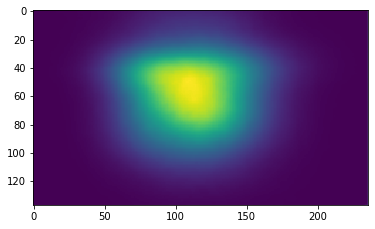

In [139]:
Df_np = 255 - Df.iloc[:,1:].values.reshape(50210, 137,236)
Df_np[Df_np < 80] = 0
Df_Avg = Df_np[:,:,:].mean(axis = 0)
plt.imshow(Df_Avg)

In [140]:
summary(Df_Avg)

,0,1,2,3,4,5,6,7,8,9,10
Oper,Min,1%,10%,25%,median,mean,75%,90%,99%,max,std
Value,0.00193189,0.01396,0.0687094,0.3739,3.03603,10.5104,14.2093,35.7892,58.0945,61.3941,15.1264


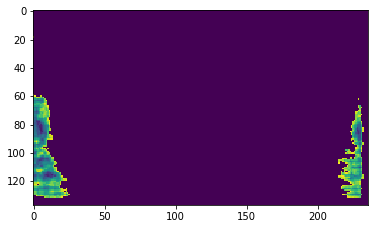

In [141]:
Df_Avg[Df_Avg > np.percentile(Df_Avg,5)] = 0
plt.imshow(Df_Avg)

In [142]:
summary(Df_Avg)

,0,1,2,3,4,5,6,7,8,9,10
Oper,Min,1%,10%,25%,median,75%,90%,mean,99%,max,std
Value,0,0,0,0,0,0,0,0.00104363,0.0278431,0.0337781,0.00483341


Several of these images have lines that run along the edges of the image, so I'm gonna crop of 3 pixels off each edge

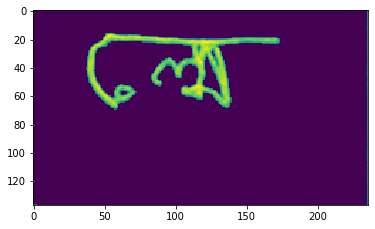

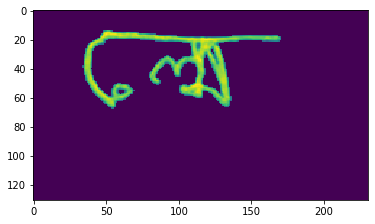

In [143]:

plt.figure()
plt.imshow(Df_np[Df_np[:,136,1] > 0][7,:,:])
plt.figure()
plt.imshow(Df_np[Df_np[:,136,1] > 0][7,2:133,3:234])

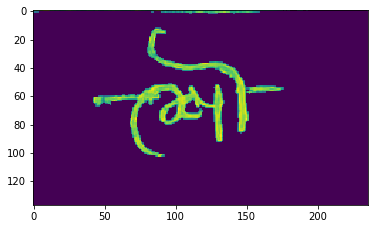

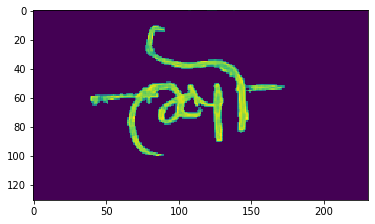

In [144]:

plt.figure()
plt.imshow(Df_np[Df_np[:,1,1] > 0][7,:,:])
plt.figure()
plt.imshow(Df_np[Df_np[:,1,1] > 0][7,2:133,3:234])

Okay, Cool now we are going to cycle through and split the images between test and train


In [224]:
rmtree('../Data/Test')
rmtree('../Data/Train')
os.mkdir('../Data/Test')
os.mkdir('../Data/Train')

Boarder_Cut = 5
Split_Level = 0.85

# Extracting it from the Data frame
Df_name = Df.iloc[:,0]
Df_name['Train'] = 0
Df_np = 255 - Df.iloc[:,1:].values.reshape(-1, 137,236).astype(np.uint8)

#cropping size of the image
Df_np = Df_np[:,Boarder_Cut:-Boarder_Cut,Boarder_Cut:-Boarder_Cut]

#Reducing noise
Df_np[Df_np < 40] = 0

for Idx in range(Df_np.shape[0]):
    Img = Df_np[Idx,:,:]
    print('../Data/Train/' + Df_name.iloc[Idx,0].astype('str') + '.jpg')
    if np.random.uniform() <= Split_Level:
        cv2.imwrite('../Data/Train/' + Df_name.iloc[Idx,0] + '.jpg', Img)
    else:
        cv2.imwrite('../Data/Test/' + Df_name.iloc[Idx,0] + '.jpg', Img)
        Df_name.iloc[Idx,1] = 1
    

/home/beltain/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


IndexingError: Too many indexers

In [231]:
Df_name = pd.DataFrame(Df.iloc[:,0].copy(), columns = ['FileName']
Df_name['Train'] = 0
Df_name

0         Train_50210
1         Train_50211
2         Train_50212
3         Train_50213
4         Train_50214
             ...     
50206    Train_100416
50207    Train_100417
50208    Train_100418
50209    Train_100419
Train               0
Name: image_id, Length: 50211, dtype: object

In [203]:
cv2.imwrite('../Data/Test/img1.jpg', Df_np[1,:,:])

True

In [217]:
np.random.uniform()

0.12455614101111256

In [205]:
?cv2.imencode

Docstring:
imencode(ext, img[, params]) -> retval, buf
.   @brief Encodes an image into a memory buffer.
.   
.   The function imencode compresses the image and stores it in the memory buffer that is resized to fit the
.   result. See cv::imwrite for the list of supported formats and flags description.
.   
.   @param ext File extension that defines the output format.
.   @param img Image to be written.
.   @param buf Output buffer resized to fit the compressed image.
.   @param params Format-specific parameters. See cv::imwrite and cv::ImwriteFlags.
Type:      builtin_function_or_method


In [206]:


def bounding_box(img):
    ce = 0
    re = 0
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    if rmax - rmin > 150: 
        print('rows was exceeded')
        re = rmax - rmin - 150
    if cmax - cmin > 150:
        print('Colums was exceeded')
        ce = cmax - cmin - 150
    return rmin, rmax, cmin, cmax, ce, re


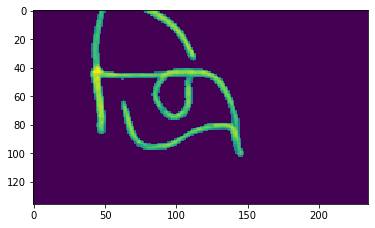

In [176]:
plt.imshow(Df_np[176,0:136,0:235])

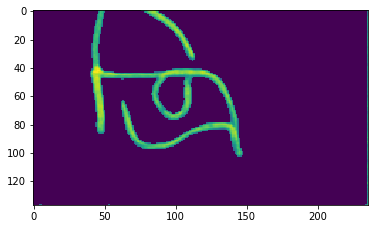

In [174]:
plt.imshow(Df_np[176,:,:])

In [ ]:
def MinniMaxxie(Arr):
    """Takes an array of an image, and centers it"""
    X_min = Arr.argmin()
    X_Max = Arr[:]
    